<a href="https://colab.research.google.com/github/freida20git/SubjectiveQA-Rater/blob/main/notebooks/siamiseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔎 “In this project, we use a Siamese-style BERT regressor to model subjective question–answer quality. Unlike traditional Siamese networks designed for similarity tasks with contrastive loss, our model processes the question and answer separately through a shared BERT encoder to produce independent semantic embeddings. These embeddings are concatenated and passed into a regression head to predict 30 continuous evaluation metrics such as answer helpfulness and question clarity. This architecture benefits from parameter sharing, interpretability, and flexibility — allowing the model to capture the nuanced contributions of both question and answer while remaining lightweight and regularized. Since our task is predicting scores rather than modeling similarity, we use MSE loss rather than contrastive loss, making this a Siamese regressor rather than a metric-learning Siamese network.”

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🧠 Siamese Network Overview
Instead of concatenating question and answer, a Siamese BERT architecture encodes each separately:

BERT_Q processes the question (title + body)

BERT_A processes the answer

Their embeddings are combined (e.g., concatenated, subtracted, or multiplied)

A regression head predicts a vector of 30 scores

This allows:

Better alignment of Q/A understanding

Generalization to unseen question or answer styles

--------------------------------------------------------------------------------
Using a single shared BERT encoder (tied weights):

✅ Forces both question and answer to be embedded in the same semantic space

✅ Helps the model compare and relate them directly (via cosine similarity, concatenation, etc.)

✅ Is more efficient (half the parameters)

✅ Encourages generalization across different input structures
--------------------------------------------------------------------------------
This is a great observation — and it's very relevant to your task. You're right that your 30 target metrics include:

🟦 Metrics related to the question (e.g., question_conversational, question_type_reason_explanation)

🟥 Metrics related to the answer (e.g., answer_helpful, answer_well_written)

🟨 And some that seem to require joint understanding (e.g., question_expect_short_answer, question_opinion_seeking)
--------------------------------------------------------------------------------for simplicity we'll use tied weights

In [ ]:
!pip install transformers datasets evaluate

In [3]:
# Imports and Dataset Preparation
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/QArater/data/filtered_data.csv').fillna("") #/content/drive/MyDrive/QArater/data /filtered_data.csv
#df = pd.read_csv('/content/filtered_data.csv').fillna("")

# Define metric columns
metric_cols = [
    'question_asker_intent_understanding', 'question_body_critical', 'question_conversational',
    'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
    'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent',
    'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
    'question_type_compare', 'question_type_consequence', 'question_type_definition',
    'question_type_entity', 'question_type_instructions', 'question_type_procedure',
    'question_type_reason_explanation', 'question_type_spelling', 'question_well_written',
    'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
    'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure',
    'answer_type_reason_explanation', 'answer_well_written'
]

# first try MODEL

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_fn(ex):
    q = "Title: " + ex["question_title"] + " [SEP] " + ex["question_body"]
    a = ex["answer"]
    ex["question_tokens"] = tokenizer(q, truncation=True, padding="max_length", max_length=256)
    ex["answer_tokens"] = tokenizer(a, truncation=True, padding="max_length", max_length=256)
    ex["labels"] = [float(ex[col]) for col in metric_cols]
    return ex

# Tokenize
dataset = Dataset.from_pandas(df)
tokenized_dataset = dataset.map(tokenize_fn)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

# PyTorch formatting
def to_torch(batch):
    return {
        'q_input_ids': torch.tensor(batch["question_tokens"]["input_ids"]),
        'q_attention_mask': torch.tensor(batch["question_tokens"]["attention_mask"]),
        'a_input_ids': torch.tensor(batch["answer_tokens"]["input_ids"]),
        'a_attention_mask': torch.tensor(batch["answer_tokens"]["attention_mask"]),
        'labels': torch.tensor(batch["labels"])
    }

train_loader = DataLoader(tokenized_dataset['train'].map(to_torch), batch_size=8, shuffle=True)
val_loader = DataLoader(tokenized_dataset['test'].map(to_torch), batch_size=8)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6079 [00:00<?, ? examples/s]

Map:   0%|          | 0/4863 [00:00<?, ? examples/s]

Map:   0%|          | 0/1216 [00:00<?, ? examples/s]

In [ ]:
#Model Definition
class SiameseBERTRegressor(nn.Module):
    def __init__(self, model_name="bert-base-uncased", hidden_size=768, out_dim=30):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.head = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_dim)
        )

    def forward(self, q_input_ids, q_attention_mask, a_input_ids, a_attention_mask):
        q_embed = self.bert(input_ids=q_input_ids, attention_mask=q_attention_mask).pooler_output
        a_embed = self.bert(input_ids=a_input_ids, attention_mask=a_attention_mask).pooler_output
        combined = torch.cat([q_embed, a_embed], dim=1)
        return self.head(combined)

In [ ]:
# STEP 3: Training and Evaluation

from torch.utils.data import DataLoader
from torch.optim import AdamW  # ✅ Use AdamW from PyTorch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import torch

# --- Collate Function ---
def collate_fn(batch):
    q_input_ids = torch.tensor([b["question_tokens"]["input_ids"] for b in batch])
    q_attention_mask = torch.tensor([b["question_tokens"]["attention_mask"] for b in batch])
    a_input_ids = torch.tensor([b["answer_tokens"]["input_ids"] for b in batch])
    a_attention_mask = torch.tensor([b["answer_tokens"]["attention_mask"] for b in batch])
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.float)
    return q_input_ids, q_attention_mask, a_input_ids, a_attention_mask, labels

# --- DataLoaders ---
train_loader = DataLoader(tokenized_dataset["train"], batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(tokenized_dataset["test"], batch_size=8, collate_fn=collate_fn)

# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseBERTRegressor().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.MSELoss()

train_losses, val_losses = [], []


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


Epoch 1 | Train Loss: 0.0323 | Val MSE: 0.0428 | MAE: 0.1392 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0170, Pearson=0.288
  - question_body_critical: MSE=0.0313, Pearson=0.608
  - question_conversational: MSE=0.0259, Pearson=0.527


/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


Epoch 2 | Train Loss: 0.0288 | Val MSE: 0.0435 | MAE: 0.1342 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0162, Pearson=0.308
  - question_body_critical: MSE=0.0324, Pearson=0.617
  - question_conversational: MSE=0.0261, Pearson=0.507


/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


Epoch 3 | Train Loss: 0.0254 | Val MSE: 0.0446 | MAE: 0.1363 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0164, Pearson=0.304
  - question_body_critical: MSE=0.0305, Pearson=0.631
  - question_conversational: MSE=0.0257, Pearson=0.535


/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


Epoch 4 | Train Loss: 0.0223 | Val MSE: 0.0460 | MAE: 0.1387 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0168, Pearson=0.301
  - question_body_critical: MSE=0.0316, Pearson=0.633
  - question_conversational: MSE=0.0276, Pearson=0.506


/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


Epoch 5 | Train Loss: 0.0197 | Val MSE: 0.0471 | MAE: 0.1381 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0181, Pearson=0.257
  - question_body_critical: MSE=0.0319, Pearson=0.628
  - question_conversational: MSE=0.0259, Pearson=0.508


/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


Epoch 6 | Train Loss: 0.0173 | Val MSE: 0.0476 | MAE: 0.1396 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0177, Pearson=0.271
  - question_body_critical: MSE=0.0317, Pearson=0.624
  - question_conversational: MSE=0.0262, Pearson=0.522


/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


Epoch 7 | Train Loss: 0.0155 | Val MSE: 0.0481 | MAE: 0.1405 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0183, Pearson=0.246
  - question_body_critical: MSE=0.0306, Pearson=0.631
  - question_conversational: MSE=0.0265, Pearson=0.492


/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


Epoch 8 | Train Loss: 0.0138 | Val MSE: 0.0481 | MAE: 0.1403 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0181, Pearson=0.242
  - question_body_critical: MSE=0.0314, Pearson=0.635
  - question_conversational: MSE=0.0267, Pearson=0.495


/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


Epoch 9 | Train Loss: 0.0127 | Val MSE: 0.0488 | MAE: 0.1406 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0183, Pearson=0.259
  - question_body_critical: MSE=0.0305, Pearson=0.643
  - question_conversational: MSE=0.0265, Pearson=0.511
Epoch 10 | Train Loss: 0.0116 | Val MSE: 0.0497 | MAE: 0.1415 | Pearson: nan | Spearman: nan
  - question_asker_intent_understanding: MSE=0.0192, Pearson=0.236
  - question_body_critical: MSE=0.0309, Pearson=0.637
  - question_conversational: MSE=0.0267, Pearson=0.476


/tmp/ipython-input-10-3548690255.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
/tmp/ipython-input-10-3548690255.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])


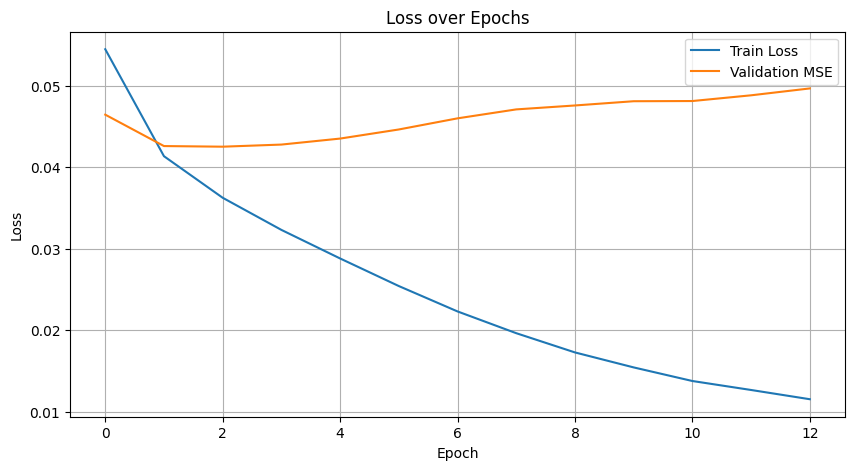

In [ ]:

# --- Evaluation Function ---
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for q_ids, q_mask, a_ids, a_mask, y in loader:
            q_ids, q_mask = q_ids.to(device), q_mask.to(device)
            a_ids, a_mask = a_ids.to(device), a_mask.to(device)
            y_hat = model(q_ids, q_mask, a_ids, a_mask)
            preds.append(y_hat.cpu().numpy())
            labels.append(y.numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    results = {
        "mae": mean_absolute_error(labels, preds),
        "mse": mean_squared_error(labels, preds),
        "pearson": np.mean([pearsonr(labels[:, i], preds[:, i])[0] for i in range(preds.shape[1])]),
        "spearman": np.mean([spearmanr(labels[:, i], preds[:, i]).correlation for i in range(preds.shape[1])])
    }
    return results, preds, labels

# --- Training Loop ---
for epoch in range(10):
    model.train()
    epoch_loss = 0
    for q_ids, q_mask, a_ids, a_mask, y in train_loader:
        q_ids, q_mask = q_ids.to(device), q_mask.to(device)
        a_ids, a_mask = a_ids.to(device), a_mask.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_hat = model(q_ids, q_mask, a_ids, a_mask)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    eval_metrics, preds_np, labels_np = evaluate(model, val_loader)
    val_losses.append(eval_metrics['mse'])

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val MSE: {eval_metrics['mse']:.4f} | MAE: {eval_metrics['mae']:.4f} | Pearson: {eval_metrics['pearson']:.4f} | Spearman: {eval_metrics['spearman']:.4f}")

    # Optional: Show example metric results for few dimensions
    for i, name in enumerate(metric_cols[:3]):
        mse = mean_squared_error(labels_np[:, i], preds_np[:, i])
        r = pearsonr(labels_np[:, i], preds_np[:, i])[0]
        print(f"  - {name}: MSE={mse:.4f}, Pearson={r:.3f}")

# --- Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# --- Save Model ---
model_path = "/content/drive/MyDrive/siamese_bert_qarater.pt"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")

✅ Model saved to /content/drive/MyDrive/siamese_bert_qarater.pt


# Optimizations: early stopping, weight decay, skip nan correlations, Dropout in model head

In [4]:
# --- Imports ---
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np

# --- Tokenizer and Tokenization ---
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(ex):
    q = "Title: " + ex["question_title"] + " [SEP] " + ex["question_body"]
    a = ex["answer"]
    q_tokens = tokenizer(q, truncation=True, padding="max_length", max_length=256)
    a_tokens = tokenizer(a, truncation=True, padding="max_length", max_length=256)
    return {
        "q_input_ids": q_tokens["input_ids"],
        "q_attention_mask": q_tokens["attention_mask"],
        "a_input_ids": a_tokens["input_ids"],
        "a_attention_mask": a_tokens["attention_mask"],
        "labels": [float(ex[col]) for col in metric_cols]
    }

# Load and tokenize dataset
dataset = Dataset.from_pandas(df)
tokenized_dataset = dataset.map(tokenize_fn)
tokenized_dataset.set_format(type="torch")
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_loader = DataLoader(tokenized_dataset['train'], batch_size=8, shuffle=True)
val_loader = DataLoader(tokenized_dataset['test'], batch_size=8)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6079 [00:00<?, ? examples/s]

In [9]:
df["question_body"].apply(lambda x: len(tokenizer.tokenize(x))).describe()

,question_body
count,6079.000000
mean,227.475736
std,336.998146
min,0.000000
25%,77.000000
50%,134.000000
75%,251.000000
max,6849.000000


100%|██████████| 6079/6079 [00:09<00:00, 666.40it/s] 


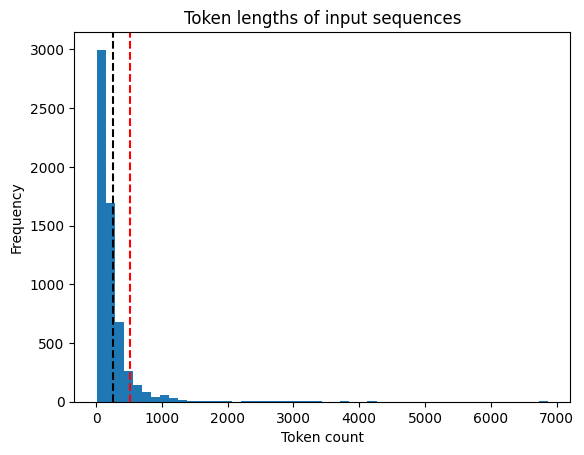

In [7]:
from tqdm import tqdm
token_lens = []

for ex in tqdm(df.to_dict("records")):
    q = "Title: " + ex["question_title"] + " [SEP] " + ex["question_body"]
    tokens = tokenizer(q)["input_ids"]
    token_lens.append(len(tokens))

import matplotlib.pyplot as plt
plt.hist(token_lens, bins=50)
plt.axvline(512, color='red', linestyle='--')
plt.axvline(256, color='black', linestyle='--')
plt.title("Token lengths of input sequences")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()


most tokens under 256 even, so its fine to make 256 as max, if more gpu available, we could use 512 which uses mopre cuda memory.

In [8]:
# --- Model Definition ---
class SiameseBERTRegressor(nn.Module):
    def __init__(self, model_name="bert-base-uncased", hidden_size=768, out_dim=30):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.head = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, out_dim)
        )

    def forward(self, q_input_ids, q_attention_mask, a_input_ids, a_attention_mask):
        q_embed = self.bert(input_ids=q_input_ids, attention_mask=q_attention_mask).pooler_output
        a_embed = self.bert(input_ids=a_input_ids, attention_mask=a_attention_mask).pooler_output
        combined = torch.cat([q_embed, a_embed], dim=1)
        return self.head(combined)


In [10]:
# --- Device, Optimizer, Loss ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseBERTRegressor().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
loss_fn = torch.nn.MSELoss()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

##without kl divergence

In [ ]:
# --- Evaluation Function ---
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            q_ids = batch['q_input_ids'].to(device)
            q_mask = batch['q_attention_mask'].to(device)
            a_ids = batch['a_input_ids'].to(device)
            a_mask = batch['a_attention_mask'].to(device)
            y = batch['labels'].to(device)

            y_hat = model(q_ids, q_mask, a_ids, a_mask)
            preds.append(y_hat.cpu().numpy())
            labels.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    pearson_vals, spearman_vals = [], []
    for i in range(preds.shape[1]):
        if np.std(labels[:, i]) == 0:
            continue
        pearson_vals.append(pearsonr(labels[:, i], preds[:, i])[0])
        spearman_vals.append(spearmanr(labels[:, i], preds[:, i]).correlation)

    results = {
        "mae": mean_absolute_error(labels, preds),
        "mse": mean_squared_error(labels, preds),
        "pearson": np.mean(pearson_vals) if pearson_vals else float("nan"),
        "spearman": np.mean(spearman_vals) if spearman_vals else float("nan")
    }
    return results, preds, labels

# --- Training Loop ---
train_losses, val_losses = [], []
best_val_mse = float("inf")
epochs_without_improvement = 0
patience = 3


📊 Epoch 1
Train Loss: 0.0795

📌 Per-Metric Validation Results:
Metric Name                                     MSE        MAE    Pearson   Spearman
--------------------------------------------------------------------------------
question_asker_intent_understanding          0.0176     0.1029      0.208      0.223
question_body_critical                       0.0406     0.1694      0.359      0.351
question_conversational                      0.0315     0.0943      0.364      0.358
question_expect_short_answer                 0.1186     0.2883      0.178      0.152
question_fact_seeking                        0.0830     0.2440      0.365      0.268
question_has_commonly_accepted_answer        0.1019     0.2684      0.391      0.353
question_interestingness_others              0.0184     0.1086      0.193      0.192
question_interestingness_self                0.0316     0.1338      0.365      0.374
question_multi_intent                        0.0999     0.2576      0.349      0.365
quest

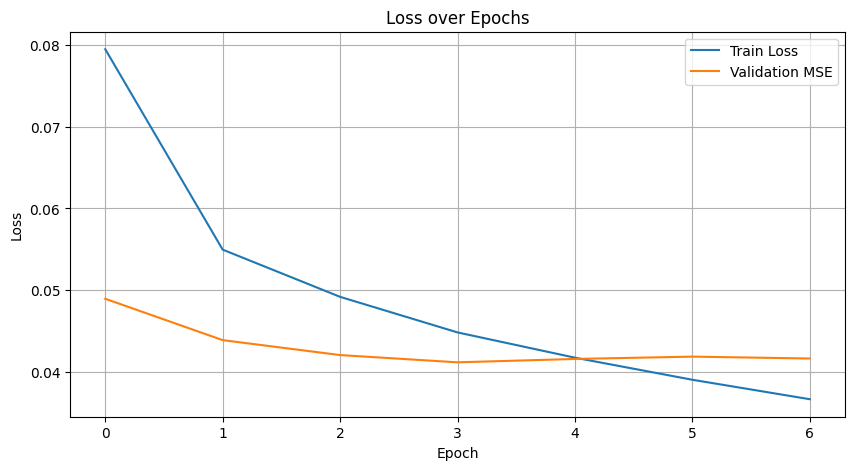

In [ ]:
for epoch in range(15):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        q_ids = batch['q_input_ids'].to(device)
        q_mask = batch['q_attention_mask'].to(device)
        a_ids = batch['a_input_ids'].to(device)
        a_mask = batch['a_attention_mask'].to(device)
        y = batch['labels'].to(device)

        optimizer.zero_grad()
        y_hat = model(q_ids, q_mask, a_ids, a_mask)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    eval_metrics, preds_np, labels_np = evaluate(model, val_loader)
    val_losses.append(eval_metrics["mse"])

    print(f"\n📊 Epoch {epoch+1}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    #print(f"Validation → MSE: {eval_metrics['mse']:.4f} | MAE: {eval_metrics['mae']:.4f} | "
    #      f"Pearson: {eval_metrics['pearson']:.4f} | Spearman: {eval_metrics['spearman']:.4f}")

    print("\n📌 Per-Metric Validation Results:")
    print(f"{'Metric Name':40} {'MSE':>10} {'MAE':>10} {'Pearson':>10} {'Spearman':>10}")
    print("-" * 80)

    for i, name in enumerate(metric_cols):
        if np.std(labels_np[:, i]) == 0:
            print(f"{name:40} {'(constant label)':>10}")
            continue
        y_true = labels_np[:, i]
        y_pred = preds_np[:, i]
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        pearson = pearsonr(y_true, y_pred)[0]
        spearman = spearmanr(y_true, y_pred).correlation
        print(f"{name:40} {mse:10.4f} {mae:10.4f} {pearson:10.3f} {spearman:10.3f}")


    if eval_metrics["mse"] < best_val_mse:
        best_val_mse = eval_metrics["mse"]
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_siamese_bert.pt")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# --- Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


##with KL divergence:

In [11]:

import torch.nn.functional as F

KL divergence
Ideal value:
 0 — this means the predicted distribution exactly matches the true distribution.

Typical range in practice (for well-trained continuous regressors turned into softmax distributions):
You’ll often see:

KL values between 0.01 and 0.5 if the model is doing reasonably well.

Values > 1.0 indicate significant divergence between the predicted and true distributions.


📊 Epoch 1
Train Loss: 0.0570
Validation → MSE: 0.0445 | MAE: 0.1467 | Pearson: 0.3434 | Spearman: 0.3235 | KL Divergence: 0.0213

📌 Per-Metric Validation Results:
Metric Name                                     MSE        MAE    Pearson   Spearman
--------------------------------------------------------------------------------
question_asker_intent_understanding          0.0186     0.1111      0.239      0.284
question_body_critical                       0.0393     0.1645      0.492      0.484
question_conversational                      0.0225     0.0915      0.444      0.386
question_expect_short_answer                 0.1131     0.2790      0.251      0.238
question_fact_seeking                        0.0795     0.2398      0.380      0.286
question_has_commonly_accepted_answer        0.0835     0.2239      0.517      0.430
question_interestingness_others              0.0173     0.1048      0.241      0.239
question_interestingness_self                0.0276     0.1242      0.477  

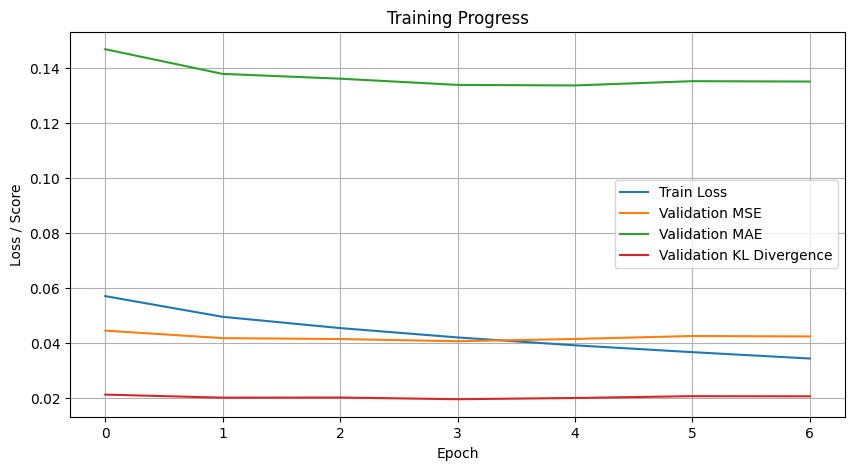

In [19]:
# --- Evaluation Function ---
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            q_ids = batch['q_input_ids'].to(device)
            q_mask = batch['q_attention_mask'].to(device)
            a_ids = batch['a_input_ids'].to(device)
            a_mask = batch['a_attention_mask'].to(device)
            y = batch['labels'].to(device)

            y_hat = model(q_ids, q_mask, a_ids, a_mask)
            preds.append(y_hat.cpu().numpy())
            labels.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    # Convert to torch tensors for KL
    preds_tensor = torch.tensor(preds, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    pred_dist = F.softmax(preds_tensor, dim=1)
    label_dist = F.softmax(labels_tensor, dim=1)

    kl_div = F.kl_div(pred_dist.log(), label_dist, reduction="batchmean").item()

    pearson_vals, spearman_vals, mse_vals, mae_vals = [], [], [], []
    for i in range(preds.shape[1]):
        if np.std(labels[:, i]) == 0:
            continue
        y_true = labels[:, i]
        y_pred = preds[:, i]
        mse_vals.append(mean_squared_error(y_true, y_pred))
        mae_vals.append(mean_absolute_error(y_true, y_pred))
        pearson_vals.append(pearsonr(y_true, y_pred)[0])
        spearman_vals.append(spearmanr(y_true, y_pred).correlation)

    results = {
        "mae": np.mean(mae_vals),
        "mse": np.mean(mse_vals),
        "pearson": np.mean(pearson_vals) if pearson_vals else float("nan"),
        "spearman": np.mean(spearman_vals) if spearman_vals else float("nan"),
        "kl_div": kl_div,
        "per_metric": {
            "mse": mse_vals,
            "mae": mae_vals,
            "pearson": pearson_vals,
            "spearman": spearman_vals
        }
    }
    return results, preds, labels

# --- Training Loop ---
train_losses, val_losses, val_maes, kl_divs = [], [], [], []
best_val_mse = float("inf")
epochs_without_improvement = 0
patience = 3

for epoch in range(15):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        q_ids = batch['q_input_ids'].to(device)
        q_mask = batch['q_attention_mask'].to(device)
        a_ids = batch['a_input_ids'].to(device)
        a_mask = batch['a_attention_mask'].to(device)
        y = batch['labels'].to(device)

        optimizer.zero_grad()
        y_hat = model(q_ids, q_mask, a_ids, a_mask)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    eval_metrics, preds_np, labels_np = evaluate(model, val_loader)
    val_losses.append(eval_metrics["mse"])
    val_maes.append(eval_metrics["mae"])
    kl_divs.append(eval_metrics["kl_div"])

    print(f"\n📊 Epoch {epoch+1}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation → MSE: {eval_metrics['mse']:.4f} | MAE: {eval_metrics['mae']:.4f} | "
          f"Pearson: {eval_metrics['pearson']:.4f} | Spearman: {eval_metrics['spearman']:.4f} | "
          f"KL Divergence: {eval_metrics['kl_div']:.4f}")

    print("\n📌 Per-Metric Validation Results:")
    print(f"{'Metric Name':40} {'MSE':>10} {'MAE':>10} {'Pearson':>10} {'Spearman':>10}")
    print("-" * 80)
    for i, name in enumerate(metric_cols):
        if np.std(labels_np[:, i]) == 0:
            print(f"{name:40} {'(constant label)':>10}")
            continue
        print(f"{name:40} {eval_metrics['per_metric']['mse'][i]:10.4f} "
              f"{eval_metrics['per_metric']['mae'][i]:10.4f} "
              f"{eval_metrics['per_metric']['pearson'][i]:10.3f} "
              f"{eval_metrics['per_metric']['spearman'][i]:10.3f}")

    if eval_metrics["mse"] < best_val_mse:
        best_val_mse = eval_metrics["mse"]
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_siamese_bert.pt")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# --- Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation MSE")
plt.plot(val_maes, label="Validation MAE")
plt.plot(kl_divs, label="Validation KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss / Score")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()

MSE penalizes larger errors more because of the square.
But if all errors are small (< 1.0), then:

MSE can actually be smaller than MAE numerically.

just because last run i didnt save the model, its same


📊 Epoch 1
Train Loss: 0.0778
Validation → MSE: 0.0474 | MAE: 0.1507 | Pearson: 0.3021 | Spearman: 0.2975 | KL Divergence: 0.0225

📌 Per-Metric Validation Results:
Metric Name                                     MSE        MAE    Pearson   Spearman
--------------------------------------------------------------------------------
question_asker_intent_understanding          0.0160     0.0973      0.273      0.310
question_body_critical                       0.0389     0.1648      0.471      0.453
question_conversational                      0.0282     0.0931      0.316      0.311
question_expect_short_answer                 0.1222     0.2966      0.170      0.160
question_fact_seeking                        0.0815     0.2368      0.341      0.286
question_has_commonly_accepted_answer        0.0918     0.2481      0.426      0.391
question_interestingness_others              0.0209     0.1115      0.329      0.344
question_interestingness_self                0.0328     0.1346      0.343  

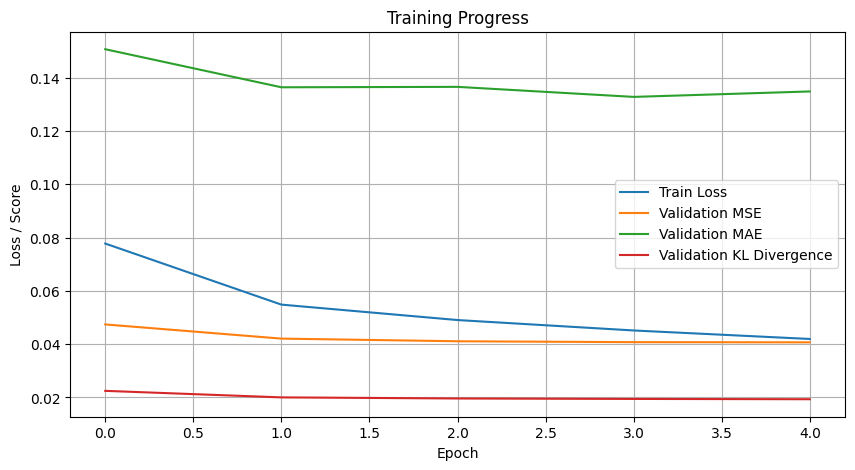

In [12]:

# --- Evaluation Function ---
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            q_ids = batch['q_input_ids'].to(device)
            q_mask = batch['q_attention_mask'].to(device)
            a_ids = batch['a_input_ids'].to(device)
            a_mask = batch['a_attention_mask'].to(device)
            y = batch['labels'].to(device)

            y_hat = model(q_ids, q_mask, a_ids, a_mask)
            preds.append(y_hat.cpu().numpy())
            labels.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    # Convert to torch tensors for KL
    preds_tensor = torch.tensor(preds, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)
    pred_dist = F.softmax(preds_tensor, dim=1)
    label_dist = F.softmax(labels_tensor, dim=1)
    kl_div = F.kl_div(label_dist.log(), pred_dist, reduction="batchmean").item()

    pearson_vals, spearman_vals, mse_vals, mae_vals = [], [], [], []
    for i in range(preds.shape[1]):
        if np.std(labels[:, i]) == 0:
            continue
        y_true = labels[:, i]
        y_pred = preds[:, i]
        mse_vals.append(mean_squared_error(y_true, y_pred))
        mae_vals.append(mean_absolute_error(y_true, y_pred))
        pearson_vals.append(pearsonr(y_true, y_pred)[0])
        spearman_vals.append(spearmanr(y_true, y_pred).correlation)

    results = {
        "mae": np.mean(mae_vals),
        "mse": np.mean(mse_vals),
        "pearson": np.mean(pearson_vals) if pearson_vals else float("nan"),
        "spearman": np.mean(spearman_vals) if spearman_vals else float("nan"),
        "kl_div": kl_div,
        "per_metric": {
            "mse": mse_vals,
            "mae": mae_vals,
            "pearson": pearson_vals,
            "spearman": spearman_vals
        }
    }
    return results, preds, labels

# --- Training Loop ---
train_losses, val_losses, val_maes, kl_divs = [], [], [], []
best_val_mse = float("inf")
epochs_without_improvement = 0
patience = 3

for epoch in range(5):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        q_ids = batch['q_input_ids'].to(device)
        q_mask = batch['q_attention_mask'].to(device)
        a_ids = batch['a_input_ids'].to(device)
        a_mask = batch['a_attention_mask'].to(device)
        y = batch['labels'].to(device)

        optimizer.zero_grad()
        y_hat = model(q_ids, q_mask, a_ids, a_mask)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    eval_metrics, preds_np, labels_np = evaluate(model, val_loader)
    val_losses.append(eval_metrics["mse"])
    val_maes.append(eval_metrics["mae"])
    kl_divs.append(eval_metrics["kl_div"])

    print(f"\n📊 Epoch {epoch+1}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation → MSE: {eval_metrics['mse']:.4f} | MAE: {eval_metrics['mae']:.4f} | "
          f"Pearson: {eval_metrics['pearson']:.4f} | Spearman: {eval_metrics['spearman']:.4f} | "
          f"KL Divergence: {eval_metrics['kl_div']:.4f}")

    print("\n📌 Per-Metric Validation Results:")
    print(f"{'Metric Name':40} {'MSE':>10} {'MAE':>10} {'Pearson':>10} {'Spearman':>10}")
    print("-" * 80)
    for i, name in enumerate(metric_cols):
        if np.std(labels_np[:, i]) == 0:
            print(f"{name:40} {'(constant label)':>10}")
            continue
        print(f"{name:40} {eval_metrics['per_metric']['mse'][i]:10.4f} "
              f"{eval_metrics['per_metric']['mae'][i]:10.4f} "
              f"{eval_metrics['per_metric']['pearson'][i]:10.3f} "
              f"{eval_metrics['per_metric']['spearman'][i]:10.3f}")

    if eval_metrics["mse"] < best_val_mse:
        best_val_mse = eval_metrics["mse"]
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_siamese_bert.pt")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# --- Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation MSE")
plt.plot(val_maes, label="Validation MAE")
plt.plot(kl_divs, label="Validation KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss / Score")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()
# Save final model
torch.save(model.state_dict(), "/content/drive/MyDrive/QArater/siamese_bert_5e.pt")


we stopped exactly where overfitting starts!

# INFERENCE EXAMPLE:

In [13]:
# Load model from Drive
model_path = "/content/drive/MyDrive/QArater/siamese_bert_5e.pt"

model = SiameseBERTRegressor()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


SiameseBERTRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [14]:
def predict(model, question_title, question_body, answer):
    model.eval()
    with torch.no_grad():
        q_text = "Title: " + question_title + " [SEP] " + question_body
        a_text = answer

        q_tokens = tokenizer(q_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
        a_tokens = tokenizer(a_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)

        q_ids = q_tokens["input_ids"].to(device)
        q_mask = q_tokens["attention_mask"].to(device)
        a_ids = a_tokens["input_ids"].to(device)
        a_mask = a_tokens["attention_mask"].to(device)

        pred = model(q_ids, q_mask, a_ids, a_mask)
        return pred.squeeze(0).cpu().numpy()  # shape: (30,)


Define Two QA Examples

In [24]:
# Metric names for x-axis
metric_names = metric_cols  # same order as your label columns

# A good QA pair
qa_good = {
    "question_title": "What is the difference between supervised and unsupervised learning?",
    "question_body": "I'm new to machine learning and would like to understand the core difference.",
    "answer": "Supervised learning uses labeled data to train models, while unsupervised learning finds patterns in unlabeled data."
}
qa_bad = {
    "question_title": "How to print hello world in python?",
    "question_body": "syntax help",
     "answer": "mix banana with chocolate"
}


In [30]:
# Metric names for x-axis
metric_names = metric_cols  # same order as your label columns

# A good QA pair
qa_good = {
    "question_title": "How to print hello world in python?",
    "question_body": "syntax help",
    "answer": "open a code enviroment, write: print('hello world') and youre done!"
}
qa_bad = {
    "question_title": "How to print hello world in python?",
    "question_body": "syntax help",
     "answer": "banana"
}


In [31]:
pred_good = predict(model, **qa_good)
pred_bad = predict(model, **qa_bad)

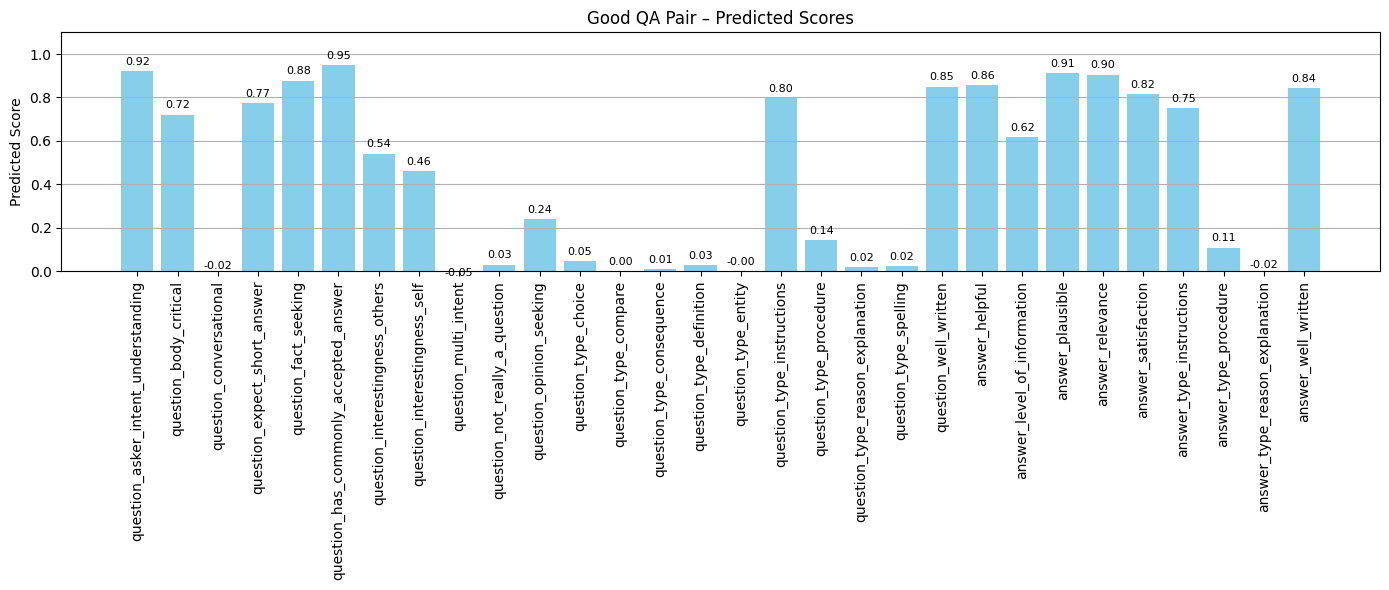

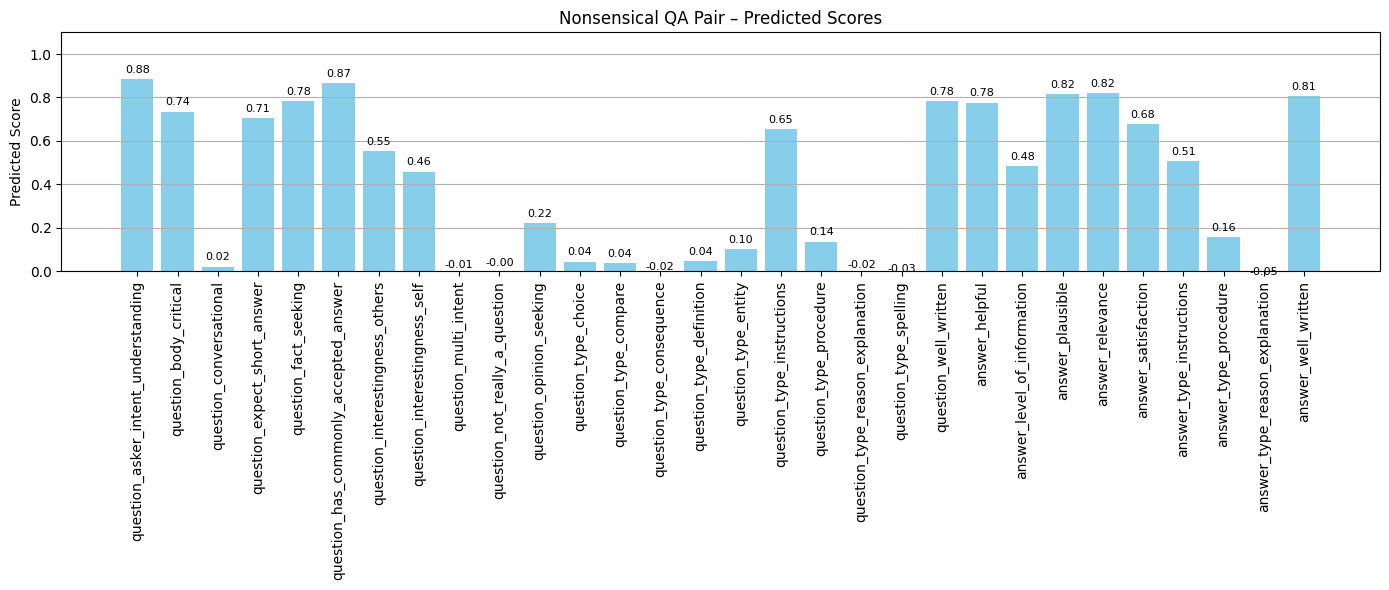

In [32]:
def plot_predictions(preds, title):
    plt.figure(figsize=(14, 6))  # Taller plot (was 14x4)
    bars = plt.bar(metric_names, preds, color='skyblue')
    plt.xticks(rotation=90)
    plt.ylim(0, 1.1)  # Allow space above bars for text
    plt.ylabel("Predicted Score")
    plt.title(title)
    plt.grid(True, axis='y')

    # Add value labels on top of bars
    for bar, score in zip(bars, preds):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{score:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_predictions(pred_good, "Good QA Pair – Predicted Scores")
plot_predictions(pred_bad, "Nonsensical QA Pair – Predicted Scores")
